In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pandas as pd
import cupy as cp

In [2]:
t=time.time()
s = cp.array(pd.read_csv("corr.csv",header=None)).astype("float32")

print(time.time()-t)
print(np.shape(s))

1302.0639533996582
(25, 2430000)


In [3]:
L=48
k=900//L
s_temp=cp.ones((25*k*k,L,L,3))
s=cp.reshape(s,(25,900,900,3))
for n in range(25):
    for i in range(k):
        for j in range(k):
            s_temp[k*k*n+k*i+j,:]=s[n,i*L:(i+1)*L,j*L:(j+1)*L,:]
s=s_temp
print(np.shape(s))

(8100, 48, 48, 3)


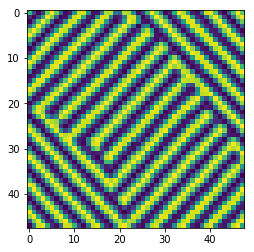

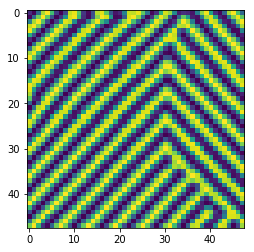

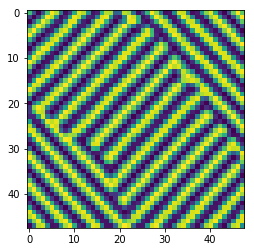

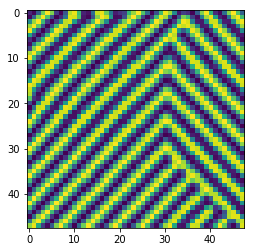

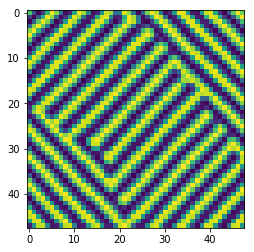

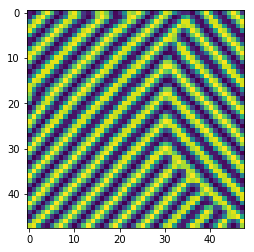

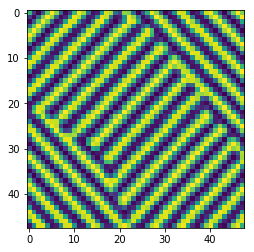

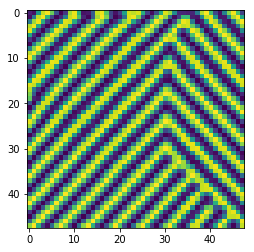

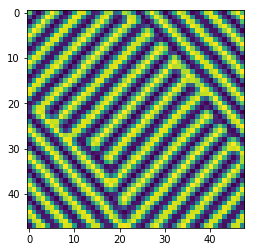

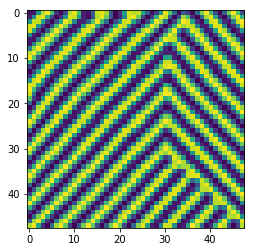

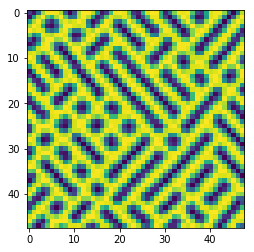

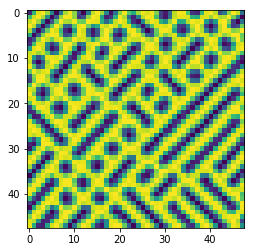

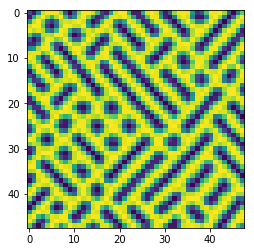

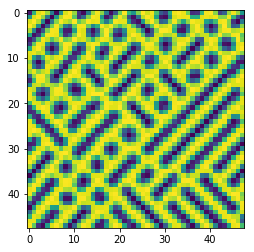

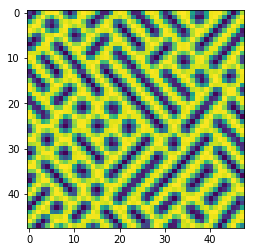

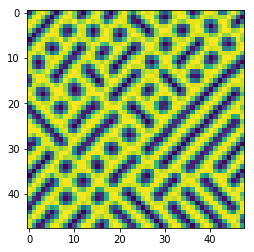

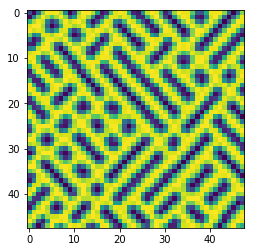

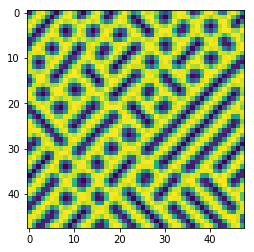

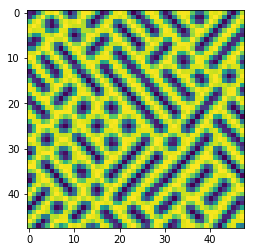

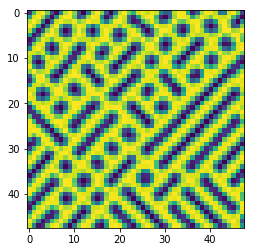

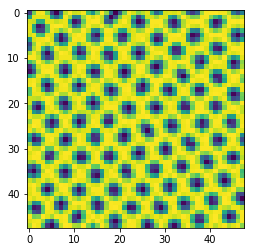

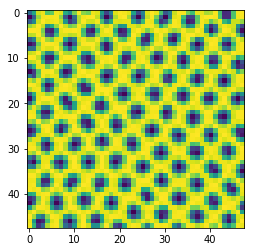

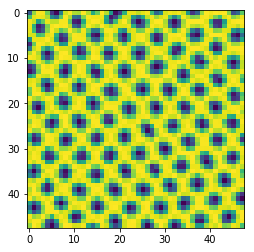

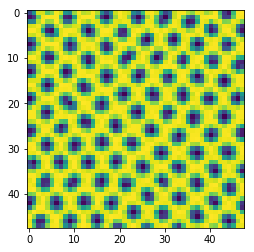

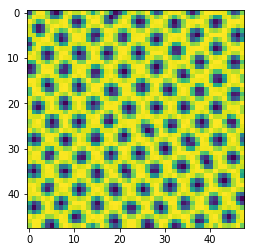

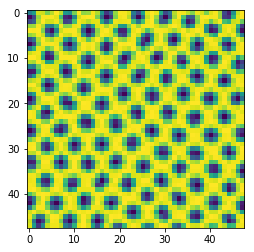

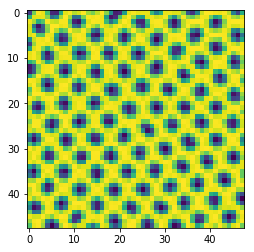

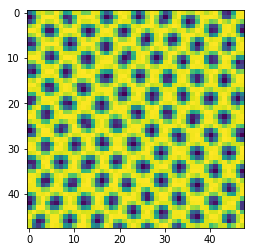

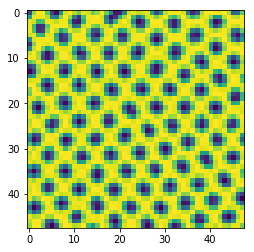

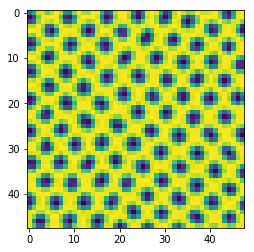

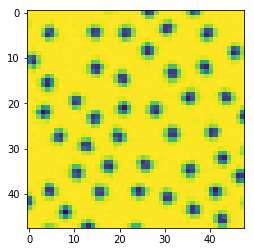

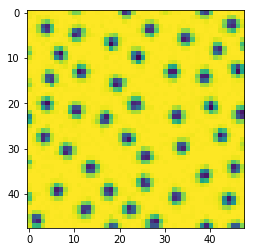

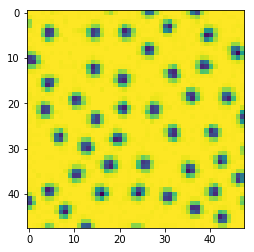

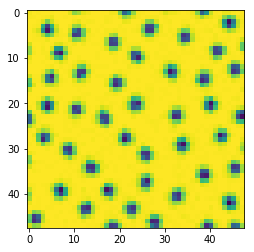

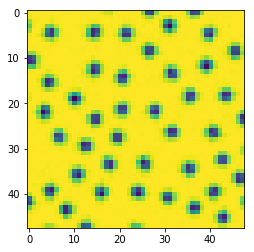

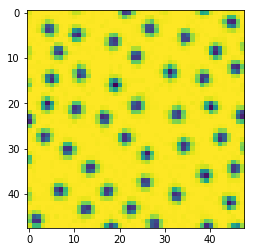

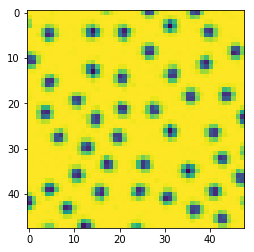

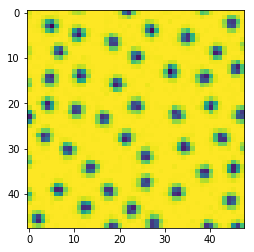

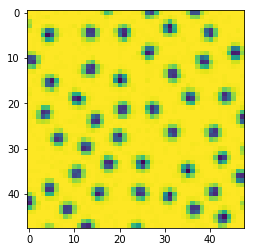

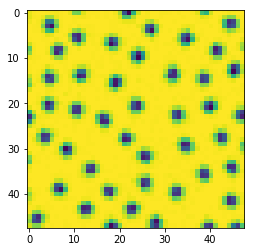

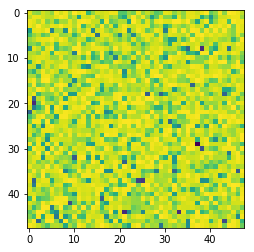

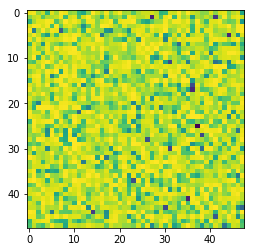

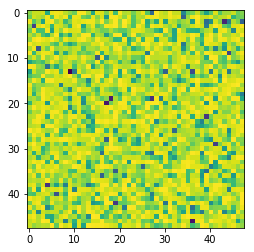

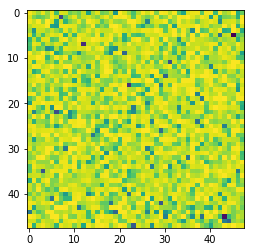

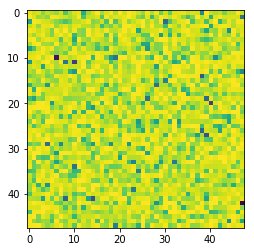

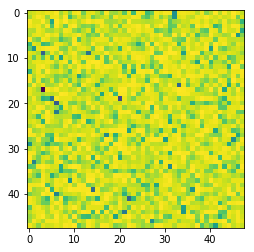

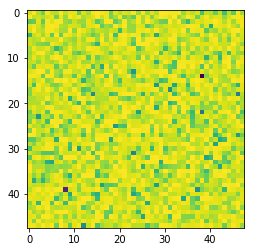

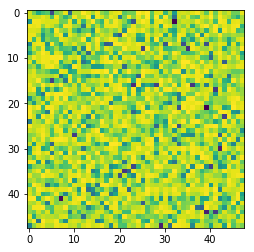

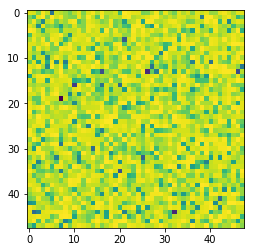

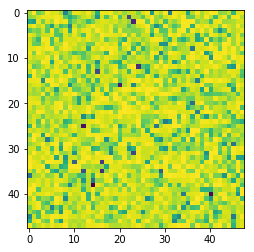

In [4]:
for i in range(np.shape(s)[0]//162):
    plt.imshow(cp.asnumpy(s[i*162,:,:,2]))
    plt.show()
s=cp.reshape(s,(-1,L*L*3))

In [5]:
s=cp.reshape(s,(-1,L,L,3))
sx=cp.reshape(s[:,:,:,0],(-1,L,L))
sy=cp.reshape(s[:,:,:,1],(-1,L,L))
sz=cp.reshape(s[:,:,:,2],(-1,L,L))
print(np.shape(sx))

(8100, 48, 48)


In [7]:
phase=4

si=cp.zeros((1,L*L*3))
sj=cp.zeros((1,L*L))
sij=cp.zeros((L*L*3,L*L*3))
sji=cp.zeros((L*L,L*L))
t=time.time()
N=np.shape(s)[0]//5
for m in range(phase*N,(phase+1)*N):
    X=cp.reshape(s[m],(1,(3*L*L)))
    #x=cp.reshape(sx[m],(1,(L*L)))
    #y=cp.reshape(sy[m],(1,(L*L)))
    #z=cp.reshape(sy[m],(1,(L*L)))
    si=si+X
    #sij=sij+cp.matmul(cp.transpose(z),z)
    #sj=sj+y
    #sji=sji+cp.matmul(cp.transpose(y),x)
    sij=sij+cp.matmul(cp.transpose(X),X)

sij=sij/N
#sji=sji/N
si=si/N
#sj=sj/N

print(time.time()-t)

12.920027494430542


In [11]:
c=sij-cp.matmul(cp.transpose(si),si)
#c=sji-cp.matmul(cp.transpose(sj),si)
#c=sji+cp.matmul(cp.transpose(sj),si)-sij-cp.matmul(cp.transpose(si),sj)
#c=sij-sji

In [12]:
print(np.max(c),np.max(sij),np.max(sji),np.max(si),np.max(sj))
print(np.mean(cp.abs(c)),np.mean(cp.abs(sij)),np.mean(cp.abs(sji)),np.mean(cp.abs(si)),np.mean(cp.abs(sj)))

0.005965506477705524 0.9902718647032936 0.0 0.9951121418196478 0.0
5.5038262256081215e-05 0.11081645878149786 0.0 0.3328160517451232 0.0


In [ ]:
s_cpu=cp.asnumpy(c)
plt.imshow(s_cpu)
plt.show()

In [10]:
image=cp.zeros((L*L))
for x in range(-L*L+1,L*L):
    image[(x+(L*L)//2+L//2)%(L*L)]+=cp.trace(c,offset=x)
np.savetxt('corr'+str(phase)+'_xy.txt',cp.asnumpy(image))

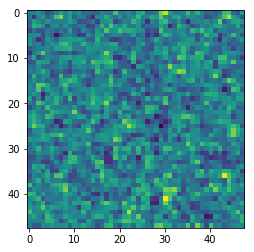

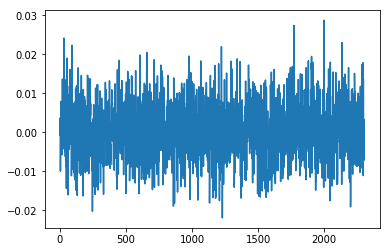

In [11]:
plt.imshow(cp.asnumpy(cp.reshape(image,(L,L))))
plt.show()
plt.plot(cp.asnumpy(image))
plt.show()

In [13]:
t=time.time()
c=cp.asnumpy(c)
lambd,W=np.linalg.eigh(c)
print(time.time()-t)

17.416179656982422


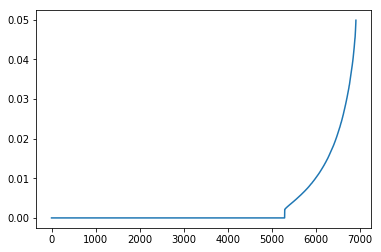

In [14]:
plt.plot(lambd[:])

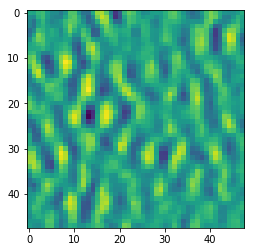

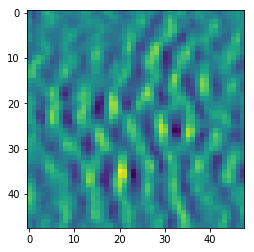

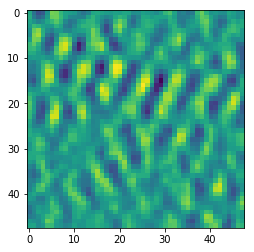

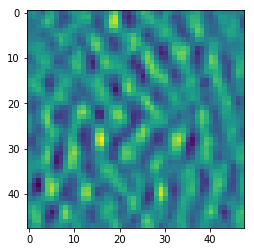

In [47]:
for i in range(1,5):
    plt.imshow(np.reshape(W[:,-i],(L,L)))
    plt.show()
    np.savetxt('eigen'+str(i+12)+'.txt',W[:,-i])

In [66]:
phase=3

si=cp.zeros((1,L*L*3))
sij=cp.zeros((L*L*3,L*L*3))
t=time.time()
N=np.shape(s)[0]//5
for m in range(phase*N,(phase+1)*N):
    temp=cp.reshape(s[m],(1,(L*L*3)))
    si=si+temp
    sij=sij+cp.matmul(cp.transpose(temp),temp)

sij=sij/N
si=si/N

print(time.time()-t)

10.68527603149414


In [67]:
c=sij-cp.matmul(cp.transpose(si),si)

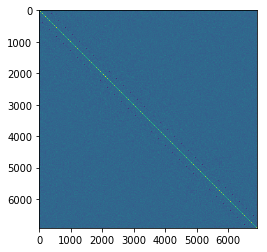

In [68]:
s_cpu=cp.asnumpy(c)
plt.imshow(s_cpu)
plt.show()

In [69]:
t=time.time()
c=cp.asnumpy(c)
lambd,W=np.linalg.eigh(c)
print(time.time()-t)

21.192869901657104


0.21755715762


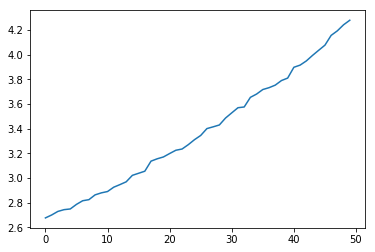

In [70]:
t=100
print(np.sum(lambd[-t:-50])/np.sum(lambd))
plt.plot(lambd[-t:-50])

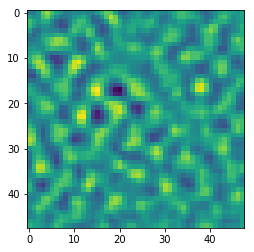

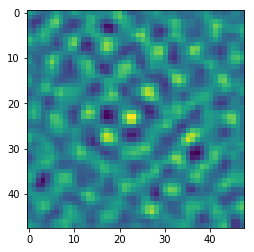

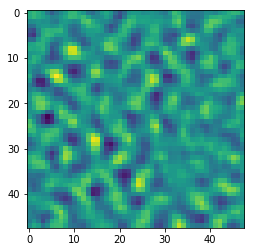

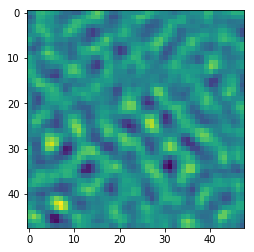

In [71]:
for i in range(1,5):
    plt.imshow(cp.reshape(W[:,-i],(L,L,3))[:,:,2])
    plt.show()
    np.savetxt('eigen'+str(i+12)+'.txt',W[:,-i])

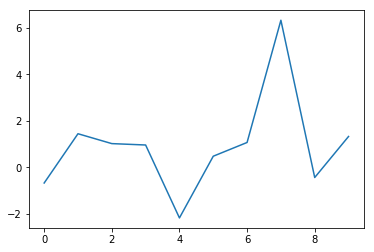

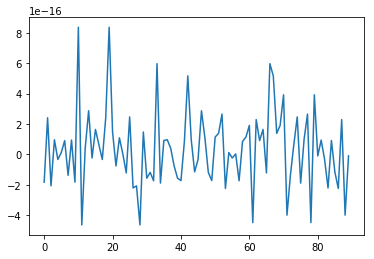

In [278]:
h=[]
g=[]
for i in range(1,11):
    h.append(np.sum(W[:,-i]))
    for j in range(1,11):
        if i!=j:
            g.append(np.sum(W[:,-i]*W[:,-j]))
plt.plot(h)
plt.show()
plt.plot(g)
plt.show()

In [279]:
p_hist=cp.zeros((99,1))
t=time.time()
for m in range(1620):
    if m%10==0:
        print(m//10,end=' ')
    #plt.imshow(np.reshape(cp.asnumpy(s[phase*N+1]),(L,L,3))[:,:,2])
    #plt.show()

    a=cp.reshape(s[phase*N+m],(1,(L*L*3)))-si
    #plt.imshow(cp.asnumpy(cp.reshape(a,(L,L,3))[:,:,2]))
    #plt.show()

    b=cp.zeros((1,(L*L*3)))
    k=100
    p1=cp.zeros((99,1))
    for i in range(1,k):
        p=cp.dot(a,cp.array(W[:,-i]))
        p1[i-1]=p
        b=b+p*cp.array(W[:,-i])

    #plt.imshow(cp.asnumpy(cp.reshape(b,(L,L,3))[:,:,2]))
    #plt.show() 
    p_hist=p_hist+(p1)**2
print(time.time()-t)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 109.16298151016235


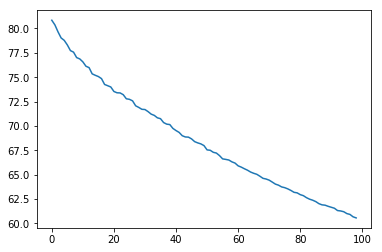

In [280]:
p_hist=cp.asnumpy(p_hist)
plt.plot(p_hist)
plt.show()

0.0499054345054 [ 80.8468039]


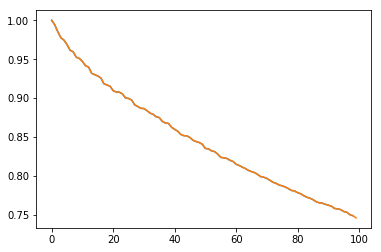

In [281]:
plt.plot(p_hist/p_hist[0])
print(lambd[-1],p_hist[0])
plt.plot(np.flip(lambd[-100:]/lambd[-1],0))
plt.show()